# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model. This will be demonstrated for Mike's example model in the California current. You are encouraged to follow along with this notebook to generate the model grid in the domain for your project.

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For Mike's model, I requested a subset covering my grid ranging from 136-114$^{\circ}$W in longitude and 28-54$^{\circ}$N in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_California.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [2]:
# read in the bathymetry grid
file_path = '/Users/surjitsingh/Desktop/CS185C/Project/GEBCO_19_Nov_2024_5e5e8b504329/gebco_2024_n24.0527_s8.2159_w64.4671_e77.8186.nc'
#'/Users/surjitsingh/Desktop/CS185C/Project/GEBCO_04_Nov_2024_0d703c968763/gebco_2024_n24.4_s8.6_w63.6_e72.0.nc'
#Old not exapaneded gebco stuff '/Users/surjitsingh/Desktop/CS185C/Project/GEBCO_Project_Bathymetry/gebco_2024_n20.3946_s8.6198_w67.6028_e76.7663.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/12
delY = 1/16
xgOrigin = 67.6028
ygOrigin = 8.6198
n_rows = 200
n_cols = 108

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

In [3]:
# Define the parameters 
delX = 1/12  # Longitude spacing
delY = 1/16  # Latitude spacing
xgOrigin = 64.4671  # New starting longitude (expanded further west)
ygOrigin = 8.2159  # Starting latitude remains the same

# Define the new boundaries
longitude_max = 77.8186  # Eastern boundary remains the same
latitude_max = 24.0527  # Expanded further north

# Calculate the number of columns and rows for the expanded area
n_cols = int((longitude_max - xgOrigin) / delX)
n_rows = int((latitude_max - ygOrigin) / delY)

# Generate the expanded grid
xc = np.arange(xgOrigin + delX / 2, xgOrigin + n_cols * delX + delX / 2, delX)
yc = np.arange(ygOrigin + delY / 2, ygOrigin + n_rows * delY + delY / 2, delY)
XC, YC = np.meshgrid(xc, yc)


print('Double check shape:', np.shape(xc),np.shape(yc))




Double check shape: (160,) (253,)


In [4]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [5]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

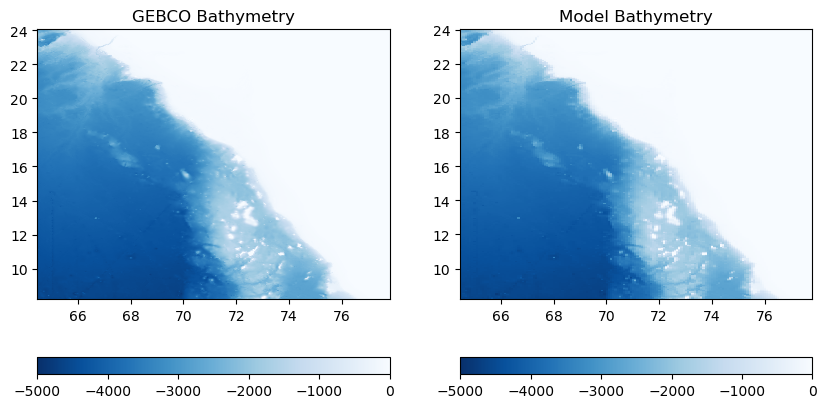

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

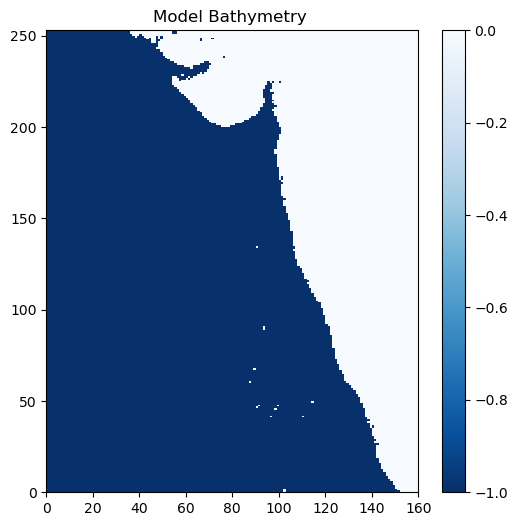

In [7]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

In [8]:
import xarray as xr


bathy_dataset = xr.Dataset({"Bathymetry": (["lat", "lon"], Model_bathy)})
bathy_dataset.to_netcdf("ModelBathymetry.nc")  # Save as NetCDF file



I do not see any areas in the land that need to be filled 

In [11]:
# fill in some areas around BC
Model_bathy_filled = np.copy(Model_bathy)
#Model_bathy_filled[342:352, 85:105] = 0
#Model_bathy_filled[282:340, 130:160] = 0
#Model_bathy_filled[325:350, 115:130] = 0

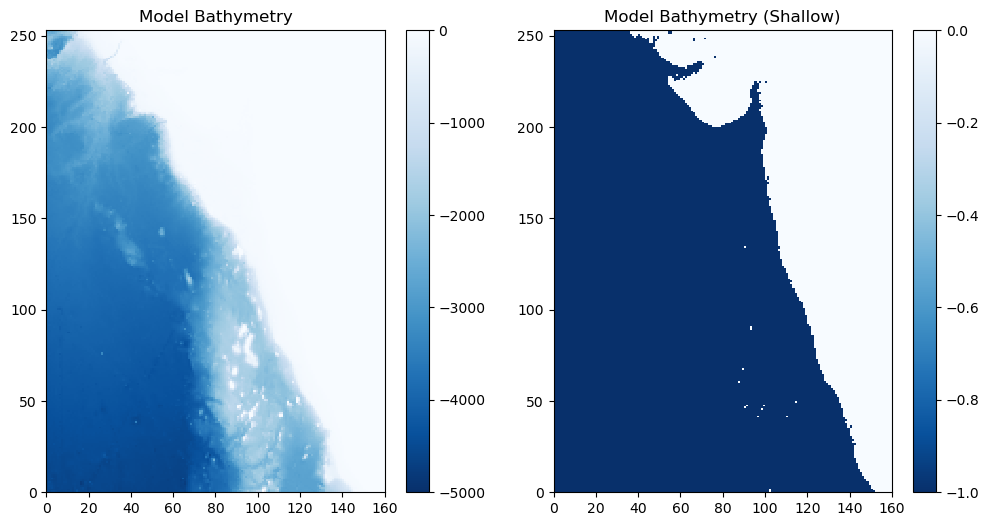

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [13]:
output_file = 'Monsoon_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)